# Classification trees (StatQuest with Josh Starmer)
- https://www.youtube.com/watch?v=q90UDEgYqeI

## Setup

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, cohen_kappa_score
from scipy.stats import hmean
import numpy as np

In [2]:
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

## Data

In [3]:
df = pd.read_csv(data_url, header = None)

### Explore

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [31]:
# https://archive.ics.uci.edu/dataset/45/heart+disease
df.columns = ["age",
"sex",
"cp",
"trestbps",
"chol",
"fbs",
"restecg",
"thalach",
"exang",
"oldpeak",
"slope",
"ca",
"thal",
"hd"]

In [8]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [9]:
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
num           int64
dtype: object

### Missing values

In [29]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

### Missing data

In [12]:
df.dtypes[df.dtypes == 'object']

ca      object
thal    object
dtype: object

In [14]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [20]:
print(f"{df.loc[df['ca'] == '?'].shape[0]}, {df.loc[df['ca'] == '?'].shape[0]/df.shape[0]:0.2%}")

4, 1.32%


In [16]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

In [21]:
print(f"{df.loc[df['thal'] == '?'].shape[0]}, {df.loc[df['thal'] == '?'].shape[0]/df.shape[0]:0.2%}")

2, 0.66%


In [23]:
df_no_missing = df.loc[(df['ca']!='?') & (df['thal'] != '?')]
df_no_missing.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [26]:
df_no_missing['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

In [27]:
df_no_missing['thal'].unique()

array(['6.0', '3.0', '7.0'], dtype=object)

In [24]:
print(f"{df_no_missing.shape[0]}, {df_no_missing.shape[0]/df.shape[0]:0.2%}")

297, 98.02%


### X

In [32]:
X = df_no_missing.drop('num', axis=1).copy()
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [48]:
X['cp']

0      1.0
1      4.0
2      4.0
3      3.0
4      2.0
      ... 
297    4.0
298    1.0
299    4.0
300    4.0
301    2.0
Name: cp, Length: 297, dtype: float64

In [51]:
pd.get_dummies(X, columns=['cp']).head() # ColumnTransformer from scikit-learn

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,cp_2.0,cp_3.0,cp_4.0
0,63.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,False,False,False
1,67.0,1.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,False,False,True
2,67.0,1.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,False,False,True
3,37.0,1.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,False,True,False
4,41.0,0.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,True,False,False


In [52]:
X_encoded = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'])
X_encoded.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,True,...,False,False,False,True,False,False,True,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,False,...,True,False,False,True,False,True,False,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,False,...,True,False,False,True,False,True,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,False,...,False,True,False,False,False,False,True,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,False,...,False,False,False,True,True,False,False,True,False,False


### y

In [61]:
y = df_no_missing[['num']].copy()
y.head()

,num
0,0
1,2
2,1
3,0
4,0


In [45]:
y['num'].unique()

array([0, 2, 1, 3, 4])

In [47]:
y.groupby(['num'])['num'].count()

num
0    160
1     54
2     35
3     35
4     13
Name: num, dtype: int64

In [68]:
y_not_zero_index = y > 0
y_simplified = y.copy()
y_simplified[y_not_zero_index] = 1
y_simplified['num'].unique()

array([0, 1])

num
0    160
1    137
Name: num, dtype: int64


<Axes: xlabel='num'>

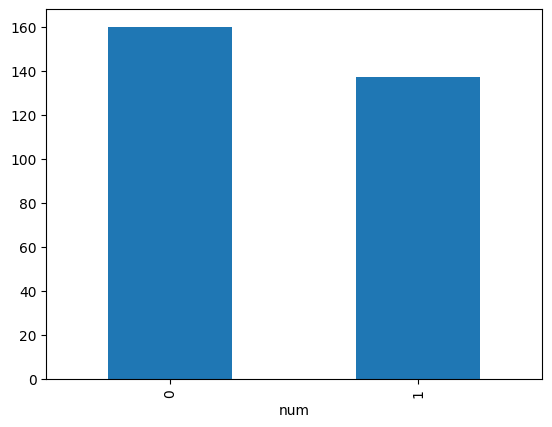

In [76]:
print(f"{y_simplified.groupby(['num'])['num'].count()}")
y_simplified.groupby(['num'])['num'].count().plot(kind='bar')

## Model

### Build

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_simplified, test_size=0.2, random_state=42)

In [95]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

[Text(0.6005208333333333, 0.9545454545454546, 'ca <= 0.5\ngini = 0.499\nsamples = 237\nvalue = [124, 113]\nclass = Heart disease: NO'),
 Text(0.3885416666666667, 0.8636363636363636, 'thal_7.0 <= 0.5\ngini = 0.384\nsamples = 139\nvalue = [103, 36]\nclass = Heart disease: NO'),
 Text(0.24791666666666667, 0.7727272727272727, 'oldpeak <= 2.7\ngini = 0.243\nsamples = 99\nvalue = [85, 14]\nclass = Heart disease: NO'),
 Text(0.1625, 0.6818181818181818, 'age <= 57.5\ngini = 0.192\nsamples = 93\nvalue = [83, 10]\nclass = Heart disease: NO'),
 Text(0.08333333333333333, 0.5909090909090909, 'chol <= 311.5\ngini = 0.062\nsamples = 62\nvalue = [60, 2]\nclass = Heart disease: NO'),
 Text(0.05, 0.5, 'trestbps <= 109.0\ngini = 0.033\nsamples = 60\nvalue = [59, 1]\nclass = Heart disease: NO'),
 Text(0.03333333333333333, 0.4090909090909091, 'sex <= 0.5\ngini = 0.32\nsamples = 5\nvalue = [4, 1]\nclass = Heart disease: NO'),
 Text(0.016666666666666666, 0.3181818181818182, 'gini = 0.0\nsamples = 3\nvalue = 

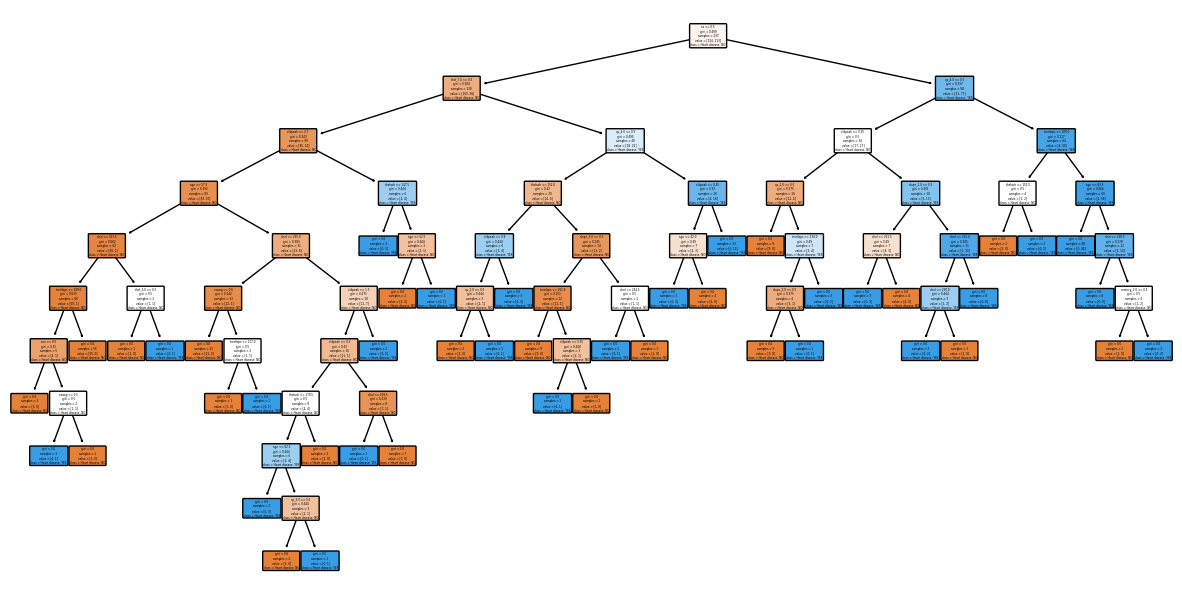

In [96]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, filled=True, rounded=True, class_names=["Heart disease: NO", "Heart disease: YES"], feature_names=X_encoded.columns)

In [103]:
y_pred = clf_dt.predict(X_test)
y_pred

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1])

In [132]:
y_proba = clf_dt.predict_proba(X_test)
y_proba_positive = y_proba[:, 1]
y_proba_positive

array([0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 1.])

### Evaluate

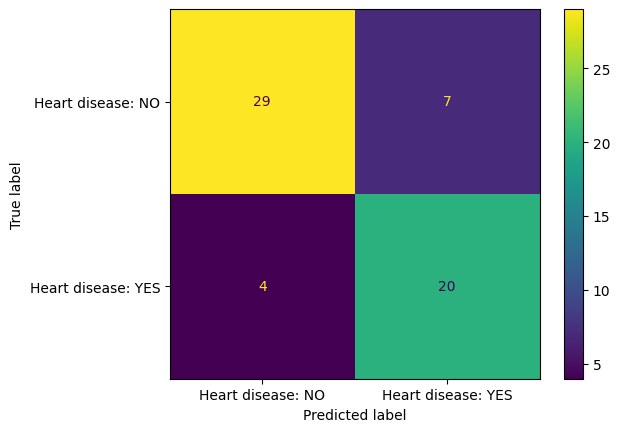

In [115]:
cm = confusion_matrix(y_test, y_pred, labels=clf_dt.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Heart disease: NO", "Heart disease: YES"]) # display_labels=clf_dt.classes_
cm_disp.plot()

In [134]:
accuracy = accuracy_score(y_test, y_pred)
print(f"{accuracy = :0.2}")

precision = precision_score(y_test, y_pred)
print(f"{precision = :0.2}")

recall = recall_score(y_test, y_pred)
print(f"{recall = :0.2}")

f1 = f1_score(y_test, y_pred)
print(f"{f1 = :0.2}")

TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
specificity = TN/(TN+FP)
print(f"{specificity = :0.2}")

MCC = (TP*TN -FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
print(f"{MCC = :0.2}")

kappa = cohen_kappa_score(y_test, y_pred)
print(f"{kappa = :0.2}")

g_mean = hmean([recall, specificity])
print(f"{g_mean = :0.2}")

youden_index = recall + specificity - 1
print(f"{youden_index = :0.2}")

roc_auc = roc_auc_score(y_test, y_proba_positive)
print(f"{roc_auc = :0.2}")
precision_vals, recal_vals, _ = precision_recall_curve(y_test, y_proba_positive)
pr_auc = auc(recal_vals, precision_vals)
print(f"{pr_auc = :0.2}")

accuracy = 0.82
precision = 0.74
recall = 0.83
f1 = 0.78
specificity = 0.81
MCC = 0.63
kappa = 0.63
g_mean = 0.82
youden_index = 0.64
roc_auc = 0.82
pr_auc = 0.82


### Prune